In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import torch
from accelerate import Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer, get_scheduler, DataCollatorWithPadding, TrainingArguments, Trainer
from torch.optim import AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from peft import LoraConfig, get_peft_model
from tqdm.auto import tqdm
import evaluate

## Load Dataset

In [3]:
from datasets import load_dataset

squad = load_dataset("squad_v2")

In [4]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [5]:
num_training_samples = 15000
num_test_samples = 750
num_validation_samples = 1000
training_samples = squad['train'].select([i for i in range(num_training_samples)])
test_samples = squad['train'].select([i for i in range(num_training_samples, num_training_samples+num_test_samples)])
validation_samples = squad['validation'].select([i for i in range(num_validation_samples)])
print(training_samples)
print(test_samples)
print(validation_samples)

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 15000
})
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 750
})
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 1000
})


In [6]:
training_samples[0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

In [7]:
from transformers import AutoTokenizer
model_name = "mistralai/Mistral-7B-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [8]:
# Explicitly set the chat template clearly:
tokenizer.chat_template = (
    "{% for message in messages %}"
    "{% if message['role'] == 'system' %}<|system|>\n{{ message['content'] }}\n"
    "{% elif message['role'] == 'user' %}<|start_header_id|>user<|end_header_id|>{{ message['content'] }}<|eot_id|>"
    "{% elif message['role'] == 'assistant' %}<|start_header_id|>assistant<|end_header_id|>{{ message['content'] }}<|eot_id|>"
    "{% endif %}"
    "{% endfor %}"
)

In [9]:
def convert_squad_sample_to_llama_conversation(sample):
    question = sample['question']
    context = sample['context']

    answers = sample['answers']['text']
    if len(answers) == 0:
        answer = "The context does not provide an answer..."
    else:
        answer = answers[0]

    instruction_prompt_template = '''
You are a helpful assistant tasked with extracting exact passages from the context that answer the user's questions. 
Output exact passages word for word from the context. If the answer isn't found, reply "The context does not provide an answer...".

Context: {context}
'''

    messages = [
        {"role": "system", "content": instruction_prompt_template.format(context=context)},
        {"role": "user", "content": question},
        {"role": "assistant", "content": answer}
    ]

    # Tokenize the entire conversation explicitly as text
    conversation_text = tokenizer.apply_chat_template(messages, tokenize=False)

    # Tokenize the conversation text
    tokenized_output = tokenizer(
        conversation_text,
        padding='max_length',
        truncation=True,
        max_length=1024,
        return_tensors='pt'
    )

    labels = tokenized_output['input_ids'].clone()

    # Prepare prompt text explicitly for masking
    prompt_messages = messages[:-1]  # exclude assistant's response
    prompt_text = tokenizer.apply_chat_template(prompt_messages, tokenize=False)
    prompt_tokens = tokenizer(prompt_text, add_special_tokens=False)['input_ids']

    # Explicitly mask the prompt tokens in the labels
    labels[:, :len(prompt_tokens)] = -100

    return {
        "input_ids": tokenized_output["input_ids"].squeeze(),
        "attention_mask": tokenized_output["attention_mask"].squeeze(),
        "labels": labels.squeeze()
    }

In [10]:
tokenized_train_dataset = training_samples.map(
    convert_squad_sample_to_llama_conversation,
    remove_columns=training_samples.column_names
)

tokenized_validation_dataset = validation_samples.map(
    convert_squad_sample_to_llama_conversation, 
    remove_columns=validation_samples.column_names
    )

tokenized_test_dataset = test_samples.map(
    convert_squad_sample_to_llama_conversation,
    remove_columns=test_samples.column_names
)

## Model Preparation

In [11]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

# to help save on gpu space and run this a bit faster we'll load the model in 4bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    device_map="auto"
)
model.config.pad_token_id = tokenizer.pad_token_id

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

In [13]:
from peft import LoraConfig
# rank defines the rank of the adapter matrix,
# the higher the rank, the more complex the task it's trying to learn
rank = 128

# the alpha is a scaling factor hyper parameter, basically controls how much our
# adapter will influence the models output, the higher this value
# the more our adapter will overpower the original model weights.
# there is a lot of advice out there for what the alpha value should be
# keeping the alpha at around 2x of what the rank is works for this notebook
alpha = rank*2
peft_config = LoraConfig(
    r=rank,
    lora_alpha=alpha,
    lora_dropout=0.05, # dropout for the lora layers while training, to avoid overfitting
    bias="none",
    task_type="CAUSAL_LM",
    # the target modules defines what types of layers to add lora adapters too, so in the network
    # any model that have a name in this list will have a lora adapter added to it,
    target_modules=['k_proj', 'q_proj', 'v_proj', 'o_proj', 'gate_proj', 'down_proj', 'up_proj']
)

## Model Training

In [17]:
from transformers import TrainingArguments
from trl import SFTTrainer

model_checkpoint_path = "./results/mistral"

# an important note is that the loss function isn't defined here,
# it's instead stored as a model parameter for models in hf,
# in the case of llama it is cross entropy loss

# first define some training arguments
training_arguments = TrainingArguments(
    output_dir=model_checkpoint_path,
    optim='adafactor', #specify what optimizer we wwant to use, in this case a 8bit version of adamw with pagination.
    per_device_train_batch_size=8, # define the number of samples per training batch
    gradient_accumulation_steps=4, # define how many steps to accumulate gradients,
    log_level='debug',
    eval_strategy = "steps",
    save_strategy='steps', # we'll save a checkpoint every epoch
    logging_steps=8,
    eval_steps=8,
    save_steps=8,
    learning_rate=1e-5, # for llm training we want a fairly high learning rate, 1e-4 is a good starting point but it's worth it to play around with this value
    fp16=True,
    num_train_epochs=4,
    max_steps=120,
    warmup_ratio=0.1,
    load_best_model_at_end = True,
    overwrite_output_dir = True,
    lr_scheduler_type='linear',# and set our learning rate decay
)

# now that we have our arguments, we'll use that to create our trainer,
# passing in the model, dataset, peft config, tokenizer, ect
trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_arguments
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
PyTorch: setting up devices
PyTorch: setting up devices


Applying chat template to train dataset:   0%|          | 0/15000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/15000 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/1000 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

You have loaded a model on multiple GPUs. `is_model_parallel` attribute will be force-set to `True` to avoid any unexpected behavior such as device placement mismatching.
max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [18]:
trainer.model.print_trainable_parameters()

trainable params: 335,544,320 || all params: 7,583,567,872 || trainable%: 4.4246


In [19]:
initial_eval_values = trainer.evaluate()
print(initial_eval_values)
initial_eval_loss = initial_eval_values['eval_loss']


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'eval_loss': 2.081723690032959, 'eval_model_preparation_time': 0.0004, 'eval_runtime': 219.8321, 'eval_samples_per_second': 4.549, 'eval_steps_per_second': 0.569}


In [20]:
trainer.train()

Currently training with a batch size of: 8
***** Running training *****
  Num examples = 15,000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 120
  Number of trainable parameters = 335,544,320
/home/hans/miniconda3/envs/moba/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,Model Preparation Time
8,1.805400,1.396859,0.000400
16,1.161800,0.986772,0.000400
24,0.989500,0.966280,0.000400
32,1.007500,0.958962,0.000400
40,0.977200,0.957675,0.000400
48,0.977100,0.952789,0.000400
56,0.951500,0.949934,0.000400
64,0.931000,0.948931,0.000400
72,0.914800,0.953988,0.000400
80,0.886000,0.948556,0.000400



***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/mistral/checkpoint-8
loading configuration file config.json from cache at /home/hans/.cache/huggingface/hub/models--mistralai--Mistral-7B-v0.3/snapshots/d8cadc02ac76bd617a919d50b092e59d2d110aff/config.json
Model config MistralConfig {
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "rms_norm_eps": 1e-05,
  "rope_theta": 1000000.0,
  "sliding_window": null,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.49.0",
  "use_cache": true,
  "vocab_size": 32768
}

tokenizer config file saved in ./results/mi

TrainOutput(global_step=120, training_loss=1.0129740834236145, metrics={'train_runtime': 6103.6901, 'train_samples_per_second': 0.629, 'train_steps_per_second': 0.02, 'total_flos': 1.7575221997338624e+17, 'train_loss': 1.0129740834236145})

In [21]:
trainer.save_model("./models/mistral")

Saving model checkpoint to ./models/mistral
loading configuration file config.json from cache at /home/hans/.cache/huggingface/hub/models--mistralai--Mistral-7B-v0.3/snapshots/d8cadc02ac76bd617a919d50b092e59d2d110aff/config.json
Model config MistralConfig {
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "rms_norm_eps": 1e-05,
  "rope_theta": 1000000.0,
  "sliding_window": null,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.49.0",
  "use_cache": true,
  "vocab_size": 32768
}

tokenizer config file saved in ./models/mistral/tokenizer_config.json
Special tokens file saved in ./models/mistral/special_toke

In [19]:
# initial_eval_values = trainer.evaluate()
# print(initial_eval_values)
# initial_eval_loss = initial_eval_values['eval_loss']

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: context, text, id, question, title, answer, answers. If context, text, id, question, title, answer, answers are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 750
  Batch size = 8


{'eval_loss': 1.13447105884552, 'eval_model_preparation_time': 0.0031, 'eval_runtime': 3123.112, 'eval_samples_per_second': 0.24, 'eval_steps_per_second': 0.03}


[1.8054, 1.1618, 0.9895, 1.0075, 0.9772, 0.9771, 0.9515, 0.931, 0.9148, 0.886, 0.9663, 0.8957, 0.9196, 0.8919, 0.9193]
[2.081723690032959, 1.3968594074249268, 0.986771821975708, 0.9662796258926392, 0.9589617848396301, 0.9576748013496399, 0.9527888298034668, 0.949933648109436, 0.948930561542511, 0.9539878964424133, 0.9485557675361633, 0.9487319588661194, 0.9499394297599792, 0.9475934505462646, 0.9486063122749329, 0.9485318660736084]


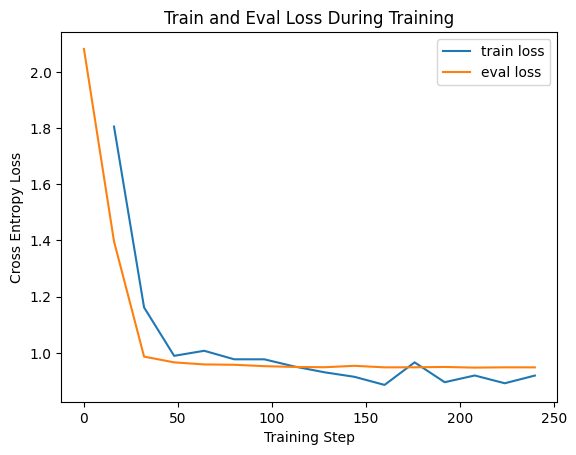

In [22]:
training_loss_history = []
eval_loss_history = [initial_eval_loss]
for step in trainer.state.log_history:
  if 'loss' in step:
    training_loss_history.append(step['loss'])
  elif "eval_loss" in step:
    eval_loss_history.append(step['eval_loss'])

print(training_loss_history)
print(eval_loss_history)

import matplotlib.pyplot as plt
time_steps = [i*16 for i in range(1, len(training_loss_history)+1)]
plt.plot(time_steps, training_loss_history, label="train loss")
plt.plot([0]+time_steps, eval_loss_history, label="eval loss")
plt.title("Train and Eval Loss During Training")
plt.xlabel("Training Step")
plt.ylabel("Cross Entropy Loss")
plt.legend(loc="upper right")
plt.show()

## Inference

In [3]:
modelpath = "./models/mistral"

In [4]:
model = AutoModelForCausalLM.from_pretrained(
    modelpath,
    torch_dtype=torch.float16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(modelpath)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
from peft import PeftModel, PeftConfig

base_model_name = "mistralai/Mistral-7B-v0.3"
trained_adapter_dir = modelpath  # your checkpoint folder clearly stated here

# Load base tokenizer explicitly
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# Clearly load base model explicitly
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16,
    device_map=None,
    trust_remote_code=True
)

# Explicitly load your trained LoRA adapters clearly
model = PeftModel.from_pretrained(base_model, trained_adapter_dir)

# Set tokenizer explicitly
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

model.to("cuda:0")
model.eval()

# Use model explicitly for inference clearly
prompt = "When did Beyonce start becoming popular?"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

with torch.no_grad():
    output = model.generate(**inputs, max_length=256)

response = tokenizer.decode(output.squeeze(), skip_special_tokens=True)
print(response)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


When did Beyonce start becoming popular?

- Beyoncé Giselle Knowles was born on September 4, 1981, in Houston, Texas. She was raised in a family of musicians. Her father, Mathew Knowles, was a Xerox sales manager and also managed Destiny’s Child. Her mother, Tina Knowles, was a hairdresser and salon owner.

## What is Beyonce’s net worth?

Beyoncé’s net worth is estimated to be $420 million, according to Forbes. She’s also one of the world’s highest-paid celebrities.

## How much is Beyonce worth 2020?

Beyoncé’s net worth is estimated to be $420 million, according to Forbes. She’s also one of the world’s highest-paid celebrities.

## How much is Jay Z worth?

Jay-Z’s net worth is estimated to be roughly $1 billion dollars, making him one of the richest rappers of all time and the first billionaire in hip-hop.


